# Capstone Two: Pre‐processing & Training Data Development


In [12]:
# 0) Imports & settings

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline       import Pipeline
from sklearn.compose        import ColumnTransformer
from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import StandardScaler, OneHotEncoder

sns.set_theme()




## 1) Load & Clean Data

I load the three cleaned CSVs, merge them on **Player**, then clean the salary column.



In [32]:
# 1.1 Load CSVs
adv = pd.read_csv("advanced_player_stats_checked.csv")   # advanced metrics
raw = pd.read_csv("nba_player_stats_checked.csv")        # box-score stats
sal = pd.read_csv("nba_salary_checked.csv")              # salary info

# 1.2 Merge on Player
df = (
    adv
    .merge(raw, on="Player", how="inner", suffixes=("_adv","_raw"))
    .merge(sal, on="Player", how="left")
)

# 1.3 Clean salary: pick first non-null across seasons, strip $/commas, convert to float
salary_cols = ["2024-25","2025-26","2026-27","2027-28","2028-29","2029-30"]
df["Salary_raw"] = df[salary_cols].bfill(axis=1).iloc[:,0]
df = df.dropna(subset=["Salary_raw"]).copy()
df["Salary"] = (
    df["Salary_raw"]
      .replace(r"[\$,]","", regex=True)
      .astype(float)
)
df.drop(columns=salary_cols + ["Salary_raw"], inplace=True)
# Drop Awards_adv because it’s 100 % NaN and carries no signal
if "Awards_adv" in df.columns:
    df = df.drop(columns=["Awards_adv"])


# Quick sanity check
print("After merge & clean:", df.shape)
df.head()


After merge & clean: (811, 62)


,Rk_adv,Player,Age_adv,Team_adv,Pos_adv,G_adv,GS_adv,MP_adv,PER,TS%,...,STL,BLK,TOV,PF,PTS,Awards_raw,Rk,Tm,Guaranteed,Salary
0,1,Mikal Bridges,28,NYK,SF,82,82,3036,14.0,0.585,...,1.0,0.4,2.1,1.5,20.3,NaN,71.0,NYK,"$48,200,000",23300000.0
1,2,Josh Hart,29,NYK,SG,77,77,2897,16.5,0.611,...,1.0,0.3,1.6,2.3,10.1,NaN,95.0,NYK,"$58,540,000",18144000.0
2,3,Anthony Edwards,23,MIN,SG,79,79,2871,20.1,0.595,...,1.3,0.5,3.1,1.8,26.6,"MVP-7,CPOY-8,AS,NBA2",21.0,MIN,"$244,623,120",42176400.0
3,4,Devin Booker,28,PHO,SG,75,75,2795,19.3,0.589,...,0.9,0.4,2.6,3.0,27.1,"AS,NBA3",7.0,PHO,"$220,441,984",49205800.0
4,5,James Harden,35,LAC,PG,79,79,2789,20.0,0.582,...,1.1,0.8,2.7,1.9,17.4,NaN,44.0,LAC,"$33,653,846",33653846.0


## 2) Multicollinearity Check 

I still want to flag any |corr| > 0.80, but `Styler.applymap` is deprecated.
Using `Styler.apply(axis=None)` keeps things future-proof.





In [34]:
# 2.1 pull numeric columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# 2.2 absolute correlation, zero the diagonal so I only see cross-feature pairs
corr_matrix = df[numeric_cols].corr().abs()
np.fill_diagonal(corr_matrix.values, 0)

# 2.3 helper that returns an array of CSS strings same shape as the DataFrame
def highlight_corr(dataframe):
    mask = (dataframe > 0.8) & (dataframe < 1)
    return np.where(mask, "background-color: orange", "")

# 2.4 display nicely
(corr_matrix
 .style
 .apply(highlight_corr, axis=None))     # axis=None = element-wise


,Rk_adv,Age_adv,G_adv,GS_adv,MP_adv,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Rk_raw,Age_raw,G_raw,GS_raw,MP_raw,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Rk,Salary
Rk_adv,0.000000,0.045107,0.773516,0.783168,0.907766,0.349230,0.216430,0.069123,0.015932,0.248211,0.046000,0.135144,0.350181,0.054633,0.081709,0.075458,0.345820,0.643476,0.754130,0.735469,0.271978,0.463387,0.044339,0.400225,0.547481,0.686039,0.045107,0.508302,0.632912,0.684877,0.415391,0.378510,0.127605,0.308648,0.230294,0.199920,0.226739,0.225859,0.054017,0.218935,0.299263,0.258885,0.105261,0.221594,0.002376,0.099290,0.302402,0.120576,0.073661,0.134140,0.300488,0.455196,0.662477,0.547689
Age_adv,0.045107,0.000000,0.004451,0.055587,0.025020,0.090721,0.063827,0.141037,0.168185,0.054817,0.119511,0.104782,0.022866,0.116353,0.029419,0.044026,0.169808,0.071469,0.001051,0.048161,0.025910,0.017155,0.062172,0.040094,0.040158,0.214468,1.000000,0.068435,0.134458,0.153746,0.090229,0.122981,0.002257,0.097958,0.026764,0.118354,0.142582,0.162270,0.045820,0.134834,0.090333,0.121906,0.138609,0.102727,0.008680,0.042728,0.142108,0.104312,0.044841,0.134396,0.096089,0.070514,0.174252,0.228676
G_adv,0.773516,0.004451,0.000000,0.638289,0.880556,0.265963,0.221454,0.019449,0.069205,0.152337,0.057228,0.100878,0.160887,0.012920,0.009159,0.112780,0.167170,0.585997,0.758999,0.699213,0.285836,0.363394,0.150115,0.361266,0.454597,0.452901,0.004451,0.407795,0.389097,0.464245,0.261106,0.213827,0.131258,0.248421,0.171681,0.164073,0.110868,0.090654,0.095057,0.233998,0.148676,0.129341,0.031374,0.114279,0.002510,0.050380,0.166538,0.041944,0.025901,0.005832,0.185938,0.287128,0.433154,0.279434
GS_adv,0.783168,0.055587,0.638289,0.000000,0.869678,0.388998,0.201149,0.133340,0.030940,0.129068,0.048259,0.018312,0.311653,0.044745,0.016830,0.065871,0.371932,0.695088,0.766117,0.776152,0.271378,0.449216,0.052072,0.391646,0.645653,0.605257,0.055587,0.416707,0.691442,0.637744,0.429816,0.360907,0.172883,0.196508,0.126447,0.114552,0.305559,0.295542,0.065052,0.211727,0.340606,0.324347,0.052465,0.128283,0.098265,0.005558,0.230909,0.094821,0.031355,0.184118,0.251478,0.453409,0.565635,0.594394
MP_adv,0.907766,0.025020,0.880556,0.869678,0.000000,0.361584,0.228788,0.039308,0.041233,0.206228,0.040236,0.112411,0.291264,0.042261,0.050800,0.117252,0.336759,0.724925,0.845222,0.827536,0.289310,0.476969,0.059377,0.417297,0.624985,0.631456,0.025020,0.481115,0.609760,0.653290,0.400697,0.363930,0.112056,0.308732,0.232928,0.178802,0.211896,0.206657,0.055224,0.215570,0.273806,0.244754,0.080915,0.195609,0.018224,0.077298,0.234468,0.109498,0.038891,0.105374,0.294503,0.437507,0.588681,0.515082
PER,0.349230,0.090721,0.265963,0.388998,0.361584,0.000000,0.620766,0.381155,0.181067,0.279042,0.443694,0.433287,0.351883,0.105696,0.249633,0.299170,0.550381,0.573131,0.428959,0.557202,0.819195,0.896259,0.342976,0.884037,0.612654,0.363014,0.090721,0.302028,0.404547,0.394519,0.524161,0.344538,0.388195,0.065001,0.130715,0.063657,0.547876,0.501714,0.198991,0.291670,0.437638,0.472951,0.080233,0.260330,0.409634,0.388643,0.133604,0.057232,0.232530,0.174556,0.014138,0.492995,0.387342,0.420879
TS%,0.216430,0.063827,0.221454,0.201149,0.228788,0.620766,0.000000,0.087807,0.083288,0.110693,0.161904,0.164429,0.035281,0.139434,0.162574,0.045546,0.016574,0.373985,0.218122,0.340123,0.760204,0.617606,0.242103,0.617483,0.285081,0.182977,0.063827,0.178884,0.169265,0.181914,0.078885,0.013545,0.191253,0.036467,0.080380,0.078290,0.098140,0.055385,0.115333,0.215304,0.095408,0.132452,0.071015,0.116831,0.198014,0.183705,0.076586,0.049882,0.154357,0.061885,0.086843,0.077019,0.227200,0.163309
3PAr,0.069123,0.141037,0.019449,0.133340,0.039308,0.381155,0.087807,0.000000,0.344468,0.581309,0.443544,0.559383,0.128632,0.012381,0.413894,0.310874,0.128608,0.157759,0.143325,0.162171,0.212192,0.080520,0.172175,0.139043,0.124363,0.013279,0.141037,0.012472,0.113147,0.042628,0.247764,0.039928,0.64

## 3) Numeric vs. Categorical Overview

I compare mean Salary and mean PER by position (`Pos_adv`).


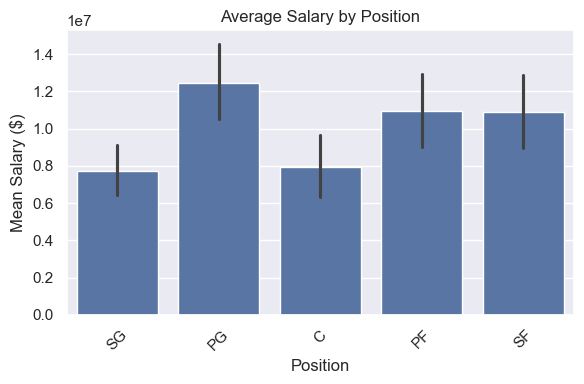

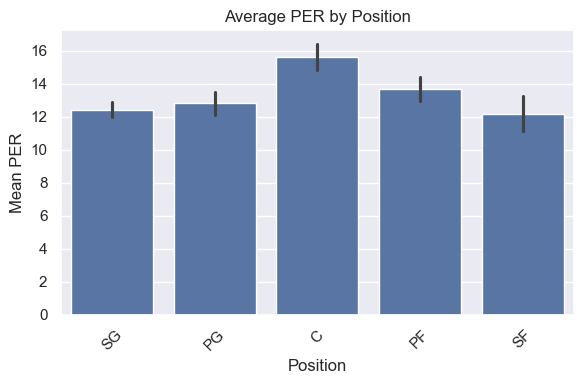

In [35]:
# Ensure figures folder exists
os.makedirs("figures", exist_ok=True)

# 3.1 Mean Salary by position
plt.figure(figsize=(6,4))
sns.barplot(
    data=df, x="Pos_adv", y="Salary",
    estimator=np.mean,
    order=df["Pos_adv"].value_counts().index
)
plt.title("Average Salary by Position")
plt.xlabel("Position")
plt.ylabel("Mean Salary ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/avg_salary_by_position.png")
plt.show()

# 3.2 Mean PER by position
plt.figure(figsize=(6,4))
sns.barplot(
    data=df, x="Pos_adv", y="PER",
    estimator=np.mean,
    order=df["Pos_adv"].value_counts().index
)
plt.title("Average PER by Position")
plt.xlabel("Position")
plt.ylabel("Mean PER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/avg_PER_by_position.png")
plt.show()


## 4) Features, Target & Train/Test Split

I drop identifiers and future-salary columns, then split 75/25 with `random_state=42`.


In [36]:
# 4.1 Define target
y = df["Salary"]

# 4.2 Drop non-feature cols (corrected column names)
drop_cols = [
    "Player", "Tm",         # salary df “Tm” column
    "Team_adv","Team_raw",  # team from adv/raw merges
    "Rk_adv","Rk_raw",      # rank columns
    "Age_adv","Age_raw",    # duplicate age
    "Pos_adv","Pos_raw"     # duplicate position
]
X = df.drop(columns=drop_cols + ["Salary"])

# 4.3 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (608, 51) X_test: (203, 51)


## 5) Numeric vs. Categorical Feature Lists

I list out which columns are numeric and which are categorical for the pipeline.


In [37]:
numeric_feats     = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_feats = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric feats:", numeric_feats)
print("Categorical feats:", categorical_feats)


Numeric feats: ['G_adv', 'GS_adv', 'MP_adv', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'G_raw', 'GS_raw', 'MP_raw', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Rk']
Categorical feats: ['Awards_raw', 'Guaranteed']


## 6) Build Preprocessing Pipeline

Median-impute + scale for numerics; most-frequent-impute + one-hot for categoricals.



In [38]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline,     numeric_feats),
    ("cat", categorical_pipeline, categorical_feats)
])


## 7) Fit & Transform

I fit the preprocessor on `X_train` then transform both training and test sets.


In [39]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)


## 8) Convert to Dense, Recover Column Names & Build DataFrames

`Awards_adv` is already dropped in Section 1, so I can go straight from the
pre-processed matrix to tidy DataFrames.




In [41]:

# 8.1  Convert sparse matrix → dense array
X_train_dense = X_train_proc.toarray()
X_test_dense  = X_test_proc.toarray()

# 8.2  Get output column names from the fitted preprocessor
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

# 8.3  Build DataFrames
print("Processed matrix shape:", X_train_dense.shape, "  #feature_names:", len(feature_names))

X_train_df = pd.DataFrame(X_train_dense, columns=feature_names, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_dense,  columns=feature_names, index=X_test.index)

# 8.4  Sanity check
print("Train DF shape:", X_train_df.shape)
print("Test  DF shape :", X_test_df.shape)



Processed matrix shape: (608, 373)   #feature_names: 373
Train DF shape: (608, 373)
Test  DF shape : (203, 373)


## 9) Quick Checks

I confirm the processed shapes match and that my target lengths are correct.


In [42]:
print("Train set shape (after preprocessing):", X_train_df.shape)
print("Test set shape  (after preprocessing):", X_test_df.shape)
print("y_train length:", len(y_train), "  y_test length:", len(y_test))


Train set shape (after preprocessing): (608, 373)
Test set shape  (after preprocessing): (203, 373)
y_train length: 608   y_test length: 203
